In [12]:
# file-handling
import os 

# user status updates
import time
from tqdm import tqdm

# the holy trinity of python
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

# scipy
import scipy
from scipy import sparse, linalg, fft
from scipy.linalg import expm, sinm, cosm
import scipy.integrate as integrate
from scipy.integrate import quad

# parallelization, memory management
from joblib import Parallel, delayed
from numba import jit, njit, prange
import copy

# itertools
import itertools

# Locals
from hamiltonian_generation import make_H3_sparse

############ Macros ###############
np.random.seed(0)

# Physical constants
K = 9 # number of fermionic modes
J = 4 # ~"energy scale"
Q_COUPLING = 3 # order of coupling, don't want to use the letter 'Q' because that denotes the supercharge
N = 2*K # number of fermions
N_DIM = 2**K # Hilbert space dimension

N_SAMPLES = 100 # number of samples to generate
N_JOBS = 20 # number of jobs to run in parallel


Just like normal SYK, we're still interested in Majorana fermions...

## Define supercharge Q

$ Q = i \sum_{1 \le i < j < k \le N} C_{ijk} \psi^i \psi^j \psi^k $

Where $\psi$ are Majorana fermions: $\{\psi^i, \psi^j \} = \delta^{ij}$,

and $C_{ijk}$ are independent Gaussian variables, with mean 0 and variance $\sigma_C^2 = \frac{2J}{N}$.

Note: "$C_{ijk}$ is a fixed, real antisymmetric tensor so that Q is hermitian" $\longleftarrow$ Pretty sure this is the same as normal SYK Hamiltonian; $J_{ijkl}$ is real and antisymmetric.

Q hermitian:  True


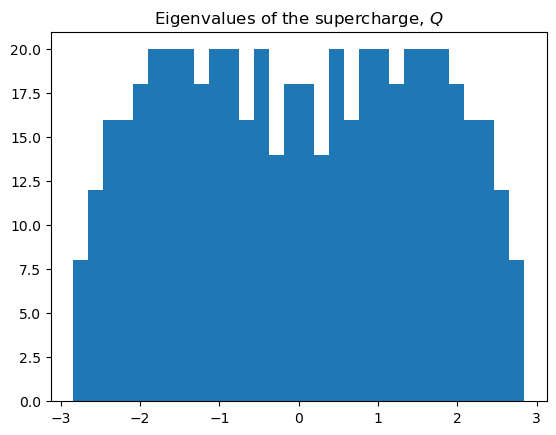

In [13]:
H3_func, psi, psi_pairs, psi_tris = make_H3_sparse(K, precompute_pairs=True, precompute_tris=True)

sigma_c = np.sqrt(2*J/(N**2))
C_test = np.random.normal(0, sigma_c, size=(N, N, N))
Q_test = H3_func(C_test).toarray()

print("Q hermitian: ", linalg.ishermitian(Q_test))

iv = np.linalg.eigvalsh(Q_test)
plt.figure()
plt.hist(iv, bins=30)
plt.title(r"Eigenvalues of the supercharge, $Q$")
plt.show()
plt.close()

Welp

## 1. Compute Hamiltonian

This one is straightforward

In [14]:
H_test = Q_test@Q_test
print("H hermitian: ", linalg.ishermitian(H_test))

H hermitian:  True


(array([96., 36., 36., 24., 28., 24., 16., 24., 16., 20., 12., 20., 12.,
        20.,  8., 12., 12., 12., 12.,  8., 12.,  8.,  8.,  8.,  8.,  4.,
         4.,  4.,  4.,  4.]),
 array([4.35442873e-06, 2.69681977e-01, 5.39359600e-01, 8.09037223e-01,
        1.07871485e+00, 1.34839247e+00, 1.61807009e+00, 1.88774772e+00,
        2.15742534e+00, 2.42710296e+00, 2.69678058e+00, 2.96645821e+00,
        3.23613583e+00, 3.50581345e+00, 3.77549108e+00, 4.04516870e+00,
        4.31484632e+00, 4.58452395e+00, 4.85420157e+00, 5.12387919e+00,
        5.39355681e+00, 5.66323444e+00, 5.93291206e+00, 6.20258968e+00,
        6.47226731e+00, 6.74194493e+00, 7.01162255e+00, 7.28130018e+00,
        7.55097780e+00, 7.82065542e+00, 8.09033305e+00]),
 <BarContainer object of 30 artists>)

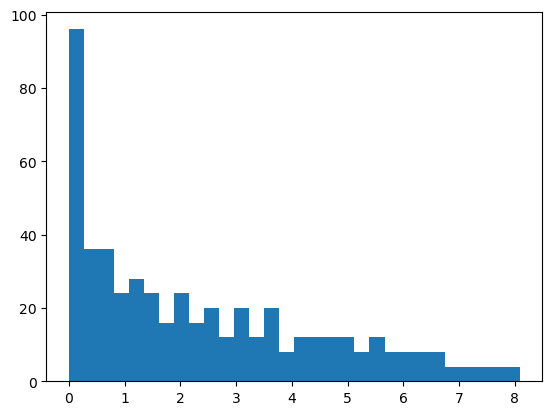

In [15]:
iv = np.linalg.eigvalsh(H_test)
plt.hist(iv, bins=30)

## 2. Check equation 1.4

$H = Q^2 = E_0 + \sum_{1\le i<j<k<l\le N} J_{ijkl} \psi^i \psi^j \psi^k \psi^l$

Where

$E_0 = \sum_{1\le i<j<k \le N} C_{ijk}^2$

and

$J_{ijkl} = -\frac{1}{8} \sum_a C_{a[ij}C_{kl]a}$

### 2.a. Let's start by computing the easy one

In [16]:
def get_E0(C):
    E0 = 0
    for i in range(N-2):
        for j in range(i+1, N-1):
            for k in range(j+1, N):
                E0 += C[i,j,k]**2
    return E0

def get_E02(C):
    C2 = C**2
    E0 = 0
    for i in range(N-2):
        for j in range(i+1, N-1):
            for k in range(j+1, N):
                E0 += C2[i,j,k]
    return E0

E0_test = get_E0(C_test)
E0_test2 = get_E02(C_test)

print(E0_test)
print(E0_test2)

19.033823252659
19.033823252659


### 2.b. And the hard one...

First, we need a function to antisymmetrize some tuple (i, j, k, l)

In [17]:
def levi_civita_tensor(dim):   
    arr=np.zeros(tuple([dim for i in range(dim)]), dtype=np.int32)
    for x in itertools.permutations(tuple(range(dim))):
        mat = np.zeros((dim, dim), dtype=np.int32)
        for i, j in zip(range(dim), x):
            mat[i, j] = 1
        arr[x]=int(np.linalg.det(mat))
    return arr

def antisymmetrize(iterable):
    n_elem = len(iterable)
    if len(set(iterable)) < n_elem:
        return 0 # <-- If there are repeated elements, levi-civita value is identically zero 

    order_0 = tuple(list(range(n_elem)))
    all_orders = list(itertools.permutations(order_0))
    all_permutations = [tuple([iterable[i] for i in order]) for order in all_orders]

    lc_tensor = levi_civita_tensor(n_elem)
    out = {}
    for i in range(len(all_orders)):
        order_i = all_orders[i]
        multiplier = lc_tensor[order_i]

        permutation_i = all_permutations[i]
        out[permutation_i] = multiplier

    return out

test_iter = (0, 1, 2)
out = antisymmetrize(test_iter)
print(out)
print(sum(out.values()))

test_iter = (0, 1, 0)
out = antisymmetrize(test_iter)
print("")
print(out)


{(0, 1, 2): 1, (0, 2, 1): -1, (1, 0, 2): -1, (1, 2, 0): 1, (2, 0, 1): 1, (2, 1, 0): -1}
0

0


$J_a = C_{a[ij}C_{kl]a}$

In [18]:
def get_J_a(C, a, i, j, k, l):
    C_left = C[a,:,:]
    C_right = C[:,:,a]

    permutations = antisymmetrize((i, j, k, l))
    out = 0
    for perm, sign in permutations.items():
        out += C_left[perm[:2]]*C_right[perm[2:]]*sign
    return out

def get_J_ijkl(C, i, j, k, l):
    sum = 0
    for a in range(N):
        sum += get_J_a(C, a, i, j, k, l)
    out = -sum/8
    return out

def get_H2(C):
    E0 = get_E0(C)
    E0 = sparse.csr_matrix(E0*np.identity(N_DIM))

    sum_J = 0
    for i in range(N-3):
        for j in range(i+1, N-2):
            index_ij = i*N+j #i*(N-1)+j
            psi_ij = psi_pairs[index_ij]

            for k in range(j+1, N-1):
                for l in range(k+1, N):
                    index_kl = k*N+l
                    psi_kl = psi_pairs[index_kl]

                    J_ijkl = get_J_ijkl(C, i, j, k, l)
                    
                    sum_J += J_ijkl*(psi_ij@psi_kl)
    
    H =  E0 + sum_J
    return H


In [19]:
tic = time.time()

H2_test = get_H2(C_test).toarray()

duration = time.time() - tic
print(f"Duration: {duration//60} minutes, {duration%60} seconds")

Duration: 0.0 minutes, 12.91156816482544 seconds


In [20]:
print(np.allclose(H_test, H2_test))

False


In [21]:
abs_diff = np.array(np.abs(H_test - H2_test))
print(np.sum(np.sum(abs_diff)))

21528.527165294734
